In [44]:
import os
import random
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

from sklearn.metrics import mean_absolute_error, confusion_matrix

from torch.utils.data import DataLoader, TensorDataset

from Hyperparameters.Embeddings.BertTokenEmbedder import BertTokenEmbedder
from Hyperparameters.Dataloader.DynamicUnderSampler import DynamicUnderSampler
from Hyperparameters.Dataloader.EmbeddingDataset import EmbeddingDataset
from Hyperparameters.Dataloader.collate_fn import collate_fn
from Hyperparameters.Models.BertPreTrainedClassifier import BertPreTrainedClassifier

from Hyperparameters.Utils.Misc import get_device



In [45]:
model_name="FacebookAI/roberta-large"
csv_path="data/Sentiment/training.csv"
seed = 42

lr = 1e-3
class_order = [0,1,2]
lr_top = 5e-5
lr_mid = 3e-5
lr_bot = 2e-5
dropout = 0.4
temperature = 0.5
ce_weight = 0.1

In [46]:
df = pd.read_csv(csv_path, index_col=0)
label_map = {'negative': -1, 'neutral': 0, 'positive': 1}
df['label_encoded'] = df['label'].map(label_map)



Split the training data

In [47]:

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['sentence'], df['label_encoded'],
    stratify=df['label_encoded'], test_size=0.1, random_state=seed
)

Balance classes

In [48]:
train_data = list(zip(train_texts, train_labels))
grouped = [[x for x in train_data if x[1] == i] for i in [-1, 0, 1]]
min_class_size = min(len(g) for g in grouped)
balanced = sum([
    resample(g, replace=False, n_samples=min_class_size, random_state=seed) for g in grouped
], [])
random.shuffle(balanced)
train_texts, train_labels = zip(*balanced)

In [49]:
embedder = BertTokenEmbedder(model_name)
X_train = embedder.fit_transform(list(train_texts))
X_val = embedder.transform(list(val_texts))

Y_train = np.array(train_labels)
Y_val = np.array(val_labels)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing batches:   0%|          | 0/1849 [00:00<?, ?it/s]

Processing batches:   0%|          | 0/320 [00:00<?, ?it/s]

Create DataLoaders

In [50]:
train_loader_frozen = None
train_loader_unfrozen = None
val_loader_frozen = None
val_loader_unfrozen = None

if embedder.is_variable_length:
    train_dataset = EmbeddingDataset(X_train, Y_train)
    val_dataset = EmbeddingDataset(X_val, Y_val)

    # Class-balanced sampler
    train_sampler = DynamicUnderSampler(Y_train, random_state=seed)


    train_loader_unfrozen = DataLoader(train_dataset, sampler=train_sampler, batch_size=8, collate_fn=collate_fn)
    val_loader_unfrozen = DataLoader(val_dataset, batch_size=64, collate_fn=collate_fn)

    cache_name= model_name.replace("/", "_")
    cache_path = "cache/" + cache_name
    cache_train_path = cache_path + "_train.pt"
    cache_val_path = cache_path + "_val.pt"


    if os.path.exists(cache_train_path):
        train_loader_frozen = torch.load(cache_train_path, weights_only=False)
    else:
        train_loader_pred = DataLoader(train_dataset, sampler=train_sampler, batch_size=8,collate_fn=collate_fn)
        train_loader_frozen = embedder.precompute_embeddings(train_loader_pred)
        os.makedirs("cache", exist_ok=True)
        torch.save(train_loader_frozen, cache_train_path)

    if os.path.exists(cache_val_path):
        val_loader_frozen = torch.load(cache_val_path, weights_only=False)
    else:
        val_loader_frozen = embedder.precompute_embeddings(val_loader_unfrozen, val=True)
        os.makedirs("cache", exist_ok=True)
        torch.save(val_loader_frozen, cache_val_path)

else:
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    Y_train_tensor = torch.tensor(Y_train, dtype=torch.long)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    Y_val_tensor = torch.tensor(Y_val, dtype=torch.long)

    train_loader_frozen = DataLoader(TensorDataset(X_train_tensor, Y_train_tensor), batch_size=32)
    train_loader_unfrozen = DataLoader(TensorDataset(X_train_tensor, Y_train_tensor), batch_size=16, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val_tensor, Y_val_tensor), batch_size=64)

In [51]:
model = BertPreTrainedClassifier(
    model_name = model_name,
    lr = lr,
    pt_lr_bot = lr_bot,
    pt_lr_mid = lr_mid,
    pt_lr_top = lr_top,
    class_order = class_order,
    ce_weight = ce_weight,
    temperature = temperature,
    frozen = True,
    custom_ll = True
)

model.to(get_device())


Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[INFO] Using device: NVIDIA GeForce RTX 3080


BertPreTrainedClassifier(
  (criterion): CustomLoss()
  (model): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_featu

Training BertPreTrainedClassifier on cuda


Training:   0%|          | 0/1233 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/639 [00:00<?, ?batch/s]

Epoch 1/6: 
Train Loss: 0.3906, Acc: 0.4850 Train Neg Acc: 0.6052, Nut Acc: 0.4142, Pos Acc: 0.6265
 Val Loss: 0.3250, Acc: 0.6137 Val Neg Acc: 0.4562, Nut Acc: 0.6689, Pos Acc: 0.8483


Training:   0%|          | 0/1233 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/639 [00:00<?, ?batch/s]

Epoch 2/6: 
Train Loss: 0.3154, Acc: 0.6210 Train Neg Acc: 0.6605, Nut Acc: 0.5458, Pos Acc: 0.7059
 Val Loss: 0.2645, Acc: 0.6850 Val Neg Acc: 0.5585, Nut Acc: 0.7290, Pos Acc: 0.7283


Training:   0%|          | 0/1233 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/639 [00:00<?, ?batch/s]

Epoch 3/6: 
Train Loss: 0.2996, Acc: 0.6433 Train Neg Acc: 0.6784, Nut Acc: 0.5716, Pos Acc: 0.7137
 Val Loss: 0.2645, Acc: 0.6850 Val Neg Acc: 0.5585, Nut Acc: 0.7290, Pos Acc: 0.7283


Training:   0%|          | 0/1233 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/639 [00:00<?, ?batch/s]

Epoch 4/6: 
Train Loss: 0.2992, Acc: 0.6442 Train Neg Acc: 0.6775, Nut Acc: 0.5720, Pos Acc: 0.7173
 Val Loss: 0.2645, Acc: 0.6850 Val Neg Acc: 0.5585, Nut Acc: 0.7290, Pos Acc: 0.7283


Training:   0%|          | 0/1233 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/639 [00:00<?, ?batch/s]

Epoch 5/6: 
Train Loss: 0.2996, Acc: 0.6432 Train Neg Acc: 0.6787, Nut Acc: 0.5726, Pos Acc: 0.7106
 Val Loss: 0.2645, Acc: 0.6850 Val Neg Acc: 0.5585, Nut Acc: 0.7290, Pos Acc: 0.7283


Training:   0%|          | 0/1233 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/639 [00:00<?, ?batch/s]

Epoch 6/6: 
Train Loss: 0.2994, Acc: 0.6454 Train Neg Acc: 0.6790, Nut Acc: 0.5746, Pos Acc: 0.7156
 Val Loss: 0.2645, Acc: 0.6850 Val Neg Acc: 0.5585, Nut Acc: 0.7290, Pos Acc: 0.7283


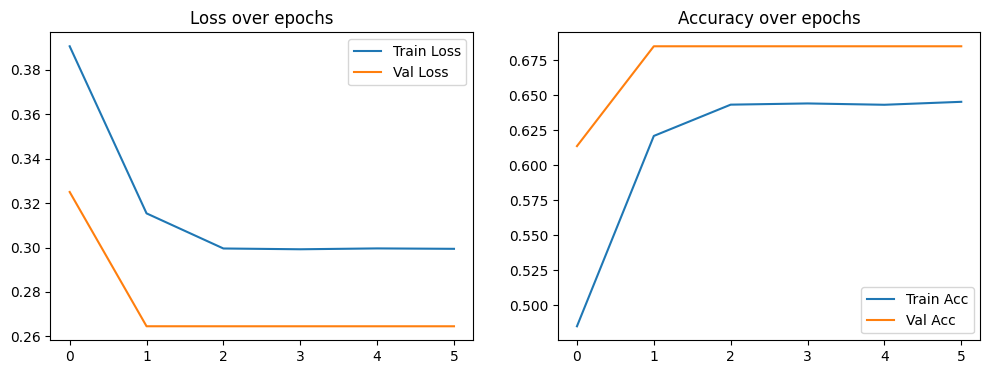

In [52]:
model.fit(train_loader_frozen, val_loader_frozen, epochs=6, plot_metrics = True, log_mlflow=False)

In [ ]:
model.unfreeze(keep_frozen=12)
model.fit(train_loader_unfrozen, val_loader_unfrozen, epochs=2, plot_metrics = True)

Training BertPreTrainedClassifier on cuda


Training:   0%|          | 0/2465 [00:00<?, ?batch/s]

In [28]:
Y_val_pred = model.predict(val_loader_unfrozen)

Predicting:   0%|          | 0/160 [00:00<?, ?batch/s]

In [29]:
mae_val = mean_absolute_error(Y_val, Y_val_pred)
L_score_val = 0.5 * (2 - mae_val)
print(f'Evaluation Score (validation set): {L_score_val:.05f}')

Evaluation Score (validation set): 0.87008


In [30]:
conf_matrix = confusion_matrix(Y_val,Y_val_pred, labels=[-1, 0, 1])
print(conf_matrix)

[[1818  222  151]
 [ 668 3773  474]
 [ 252  483 2369]]


Training BertPreTrainedClassifier on cuda


Training:   0%|          | 0/2465 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/160 [00:00<?, ?batch/s]

Epoch 1/2: 
Train Loss: 0.4377, Acc: 0.3594 Train Neg Acc: 0.7495, Nut Acc: 0.3419, Pos Acc: 0.7317
 Val Loss: 0.3729, Acc: 0.4814 Val Neg Acc: -1.0000, Nut Acc: 0.4814, Pos Acc: -1.0000


Training:   0%|          | 0/2465 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/160 [00:00<?, ?batch/s]

Epoch 2/2: 
Train Loss: 0.4500, Acc: 0.3333 Train Neg Acc: -1.0000, Nut Acc: 0.3333, Pos Acc: -1.0000
 Val Loss: 0.3729, Acc: 0.4814 Val Neg Acc: -1.0000, Nut Acc: 0.4814, Pos Acc: -1.0000


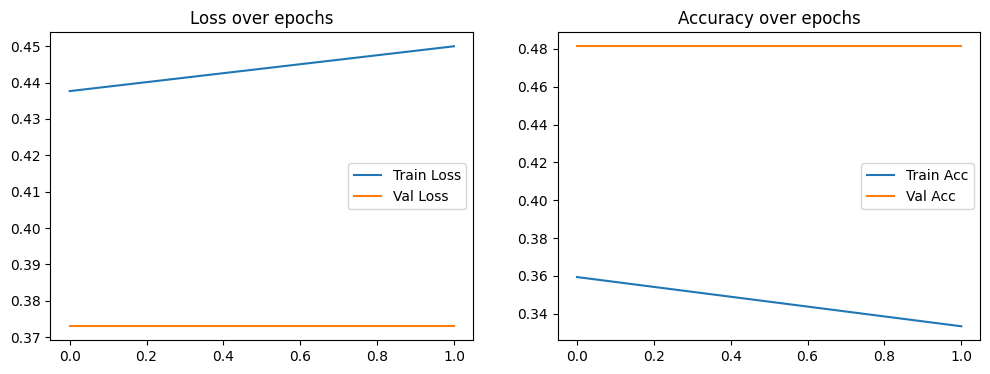

In [32]:
model.fit(train_loader_unfrozen, val_loader_unfrozen, epochs=2, plot_metrics = True)

In [33]:
Y_val_pred = model.predict(val_loader_unfrozen)

Predicting:   0%|          | 0/160 [00:00<?, ?batch/s]

In [34]:
mae_val = mean_absolute_error(Y_val, Y_val_pred)
L_score_val = 0.5 * (2 - mae_val)
print(f'Evaluation Score (validation set): {L_score_val:.05f}')

Evaluation Score (validation set): 0.74070


In [35]:
conf_matrix = confusion_matrix(Y_val,Y_val_pred, labels=[-1, 0, 1])
print(conf_matrix)

[[   0 2191    0]
 [   0 4915    0]
 [   0 3104    0]]


In [36]:
model_path = "roberta_large_12_2"
torch.save(model.state_dict(), "cache/" + model_path + ".pt")
model.model.save_pretrained("cache/" + model_path + "pretrained")
model.model.config.save_pretrained("cache/" + model_path + "_config")
model.tokenizer.save_pretrained("cache/" + model_path + "tokenizer")


('cache/roberta_large_4tokenizer\\tokenizer_config.json',
 'cache/roberta_large_4tokenizer\\special_tokens_map.json',
 'cache/roberta_large_4tokenizer\\vocab.json',
 'cache/roberta_large_4tokenizer\\merges.txt',
 'cache/roberta_large_4tokenizer\\added_tokens.json',
 'cache/roberta_large_4tokenizer\\tokenizer.json')